## Test models

I'm making some fairly substantive changes to the code, this notebook will allow me to run tests to make sure nothing is significnatly broken

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
import matplotlib.pyplot as plt

# my modules
from sn_camels.models.models_factory import baseModelFactory, topModelFactory
from sn_camels.models.sn_hybrid_models import sn_HybridModel
from sn_camels.models.camels_models import model_o3_err
from sn_camels.camels.camels_dataset import *

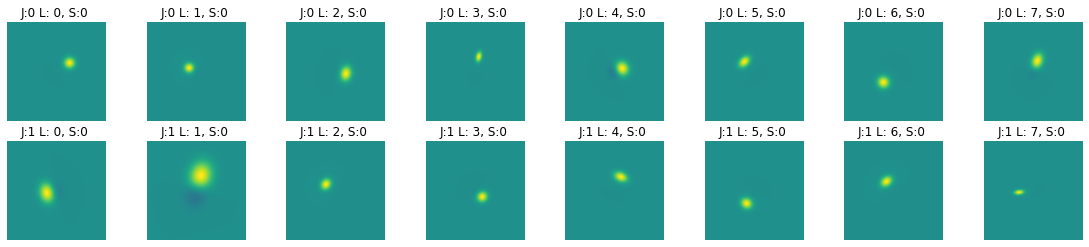

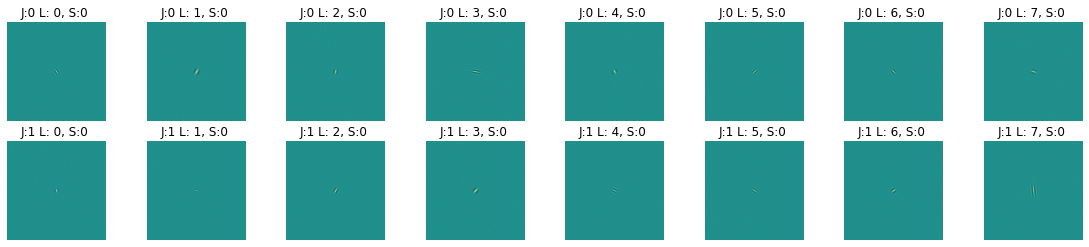

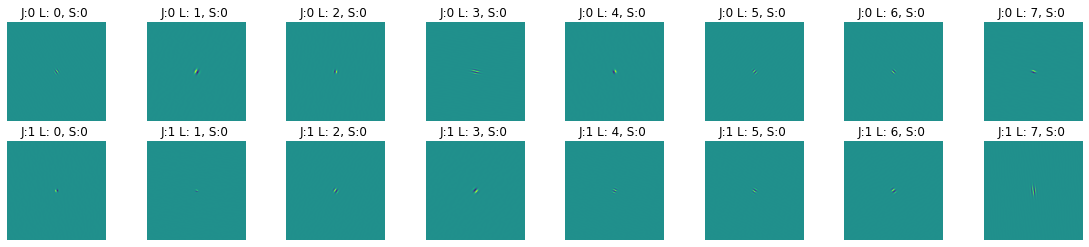

In [18]:
scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    second_order=True,
    initialization="Random",
    seed=123,
    learnable=True,
    lr_orientation=0.1,
    lr_scattering=0.1,
    skip=True,
    filter_video=False,
    device="cpu",
    use_cuda=False
)

In [20]:
top = topModelFactory( #create cnn, mlp, linearlayer, or other
    base=scatteringBase,
    architecture="cnn",
    num_classes=12, 
    width=8, 
    use_cuda=False
)


In [21]:
len(scatteringBase.scattering.psi)

16

In [22]:
hybridModel = sn_HybridModel(scatteringBase=scatteringBase, top=top, use_cuda=False) #creat hybrid model

In [6]:
## CPU only cuz i have a poopy laptop
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cpu')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory

CUDA Available


In [7]:
## camels path
camels_path=os.environ['CAMELS_PATH']

# data parameters
fmaps      = ['maps_Mcdm.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = camels_path+"/params_IllustrisTNG.txt"
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 1   #number of maps per simulation

# training parameters
channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

# optimizer parameters
beta1 = 0.5
beta2 = 0.999

# hyperparameters
batch_size = 1
lr         = 1e-3
wd         = 0.0005  #value of weight decay
dr         = 0.2    #dropout value for fully connected layers
hidden     = 5      #this determines the number of channels in the CNNs; integer larger than 1
epochs     = 10    #number of epochs to train the network

# output files names
floss  = 'loss.txt'   #file with the training and validation losses for each epoch
fmodel = 'weights.pt' #file containing the weights of the best-model

In [8]:
fmaps2 = camels_path+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

Shape of the maps: (15000, 256, 256)


In [9]:
# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):  
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_Mcdm.npy', maps)
del maps

Selected 1000 maps out of 15000


In [10]:
# get training set
print('\nPreparing training set')
train_loader = create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm, 
                                         rot_flip_in_mem=rot_flip_in_mem, verbose=True)


Preparing training set
Found 1 channels
Reading data...
3.859e+09 < F(all|orig) < 1.963e+15
9.586 < F(all|resc)  < 15.293
-2.759 < F(all|norm) < 8.501


In [11]:
## print dataset shape
train_loader.dataset.x.shape[0]

900

In [23]:
model = hybridModel
#model2 = model_o3_err(hidden, dr, channels)
model.to(device=device)

sn_HybridModel(
  (scatteringBase): sn_ScatteringBase(
    (scattering): ScatteringTorch2D()
  )
  (top): sn_CNN(
    (bn0): BatchNorm2d(273, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (init_conv): Sequential(
      (0): BatchNorm2d(273, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (1): Conv2d(273, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (layer2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

In [24]:
x,y=next(iter(train_loader))

In [25]:
model.scatteringBase.forward(x).shape

torch.Size([1, 273, 256, 256])

In [27]:
model.scatteringBase.n_coefficients

273

In [26]:
model(x)

tensor([[ 6.0783e-01, -2.7505e-02, -4.3043e-01, -4.8007e-01, -1.3207e-01,
          8.0974e-02, -2.6545e-01, -5.8889e-01,  1.4069e-03,  1.1731e-01,
          1.0600e-01, -1.7013e+00]], grad_fn=<AddmmBackward0>)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=(beta1, beta2))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

In [ ]:
h

In [ ]:
x.shape

In [ ]:
y

In [ ]:
model2.eval()

In [ ]:
p=model(x)

In [ ]:
p[:,g]

In [ ]:
p[:,h]

In [ ]:
p.shape

In [ ]:
# do a loop over all epochs for a single batch
start = time.time()
for epoch in range(100):

    # do training
    train_loss1, train_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    train_loss, points = 0.0, 0
    model.train()
    bs   = x.shape[0]         #batch size
    x    = x.to(device)       #maps
    y    = y.to(device)[:,g]  #parameters
    p    = model(x)           #NN output
    y_NN = p[:,g]             #posterior mean
    e_NN = p[:,h]             #posterior std
    loss1 = torch.mean((y_NN - y)**2,                axis=0)
    loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
    loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
    train_loss1 += loss1*bs
    train_loss2 += loss2*bs
    points      += bs
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #if points>18000:  break
    train_loss = torch.log(train_loss1/points) + torch.log(train_loss2/points)
    train_loss = torch.mean(train_loss).item()

    # do validation: cosmo alone & all params
    #valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    #valid_loss, points = 0.0, 0
    print(train_loss)

stop = time.time()
print('Time take (h):', "{:.4f}".format((stop-start)/3600.0))

In [ ]:
# do a loop over all epochs
start = time.time()
for epoch in range(epochs):

    # do training
    train_loss1, train_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        bs   = x.shape[0]         #batch size
        x    = x.to(device)       #maps
        y    = y.to(device)[:,g]  #parameters
        p    = model(x)           #NN output
        y_NN = p[:,g]             #posterior mean
        e_NN = p[:,h]             #posterior std
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
        loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
        train_loss1 += loss1*bs
        train_loss2 += loss2*bs
        points      += bs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if points>18000:  break
    train_loss = torch.log(train_loss1/points) + torch.log(train_loss2/points)
    train_loss = torch.mean(train_loss).item()

    # do validation: cosmo alone & all params
    valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    valid_loss, points = 0.0, 0
    model.eval()
    for x, y in valid_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            x     = x.to(device)       #maps
            y     = y.to(device)[:,g]  #parameters
            p     = model(x)           #NN output
            y_NN  = p[:,g]             #posterior mean
            e_NN  = p[:,h]             #posterior std
            loss1 = torch.mean((y_NN - y)**2,                axis=0)
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
            valid_loss1 += loss1*bs
            valid_loss2 += loss2*bs
            points     += bs
    valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
    valid_loss = torch.mean(valid_loss).item()

    scheduler.step(valid_loss)

    # verbose
    print('%03d %.3e %.3e '%(epoch, train_loss, valid_loss), end='')

    # save model if it is better
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), fmodel)
        min_valid_loss = valid_loss
        print('(C) ', end='')
    print('')

    # save losses to file
    f = open(floss, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, valid_loss))
    f.close()

stop = time.time()
print('Time take (h):', "{:.4f}".format((stop-start)/3600.0))

In [ ]:
# load the weights in case they exists
if os.path.exists(fmodel):  
    model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

In [ ]:
# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm, 
                                         rot_flip_in_mem=False, verbose=True)

# get the number of maps in the test set
num_maps = 0
for x,y in test_loader:
      num_maps += x.shape[0]
print('\nNumber of maps in the test set: %d'%num_maps)

# define the arrays containing the value of the parameters
params_true = np.zeros((num_maps,6), dtype=np.float32)
params_NN   = np.zeros((num_maps,6), dtype=np.float32)
errors_NN   = np.zeros((num_maps,6), dtype=np.float32)

# get test loss
test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
test_loss, points = 0.0, 0
model.eval()
for x, y in test_loader:
    with torch.no_grad():
        bs    = x.shape[0]    #batch size
        x     = x.to(device)  #send data to device
        y     = y.to(device)  #send data to device
        p     = model(x)      #prediction for mean and variance
        y_NN  = p[:,:6]       #prediction for mean
        e_NN  = p[:,6:]       #prediction for error
        loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
        loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
        test_loss1 += loss1*bs
        test_loss2 += loss2*bs

        # save results to their corresponding arrays
        params_true[points:points+x.shape[0]] = y.cpu().numpy() 
        params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
        errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
        points    += x.shape[0]
test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
test_loss = torch.mean(test_loss).item()
print('Test loss = %.3e\n'%test_loss)

Norm_error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
print('Normalized Error Omega_m = %.3f'%Norm_error[0])
print('Normalized Error sigma_8 = %.3f'%Norm_error[1])
print('Normalized Error A_SN1   = %.3f'%Norm_error[2])
print('Normalized Error A_AGN1  = %.3f'%Norm_error[3])
print('Normalized Error A_SN2   = %.3f'%Norm_error[4])
print('Normalized Error A_AGN2  = %.3f\n'%Norm_error[5])

# de-normalize
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
params_true = params_true*(maximum - minimum) + minimum
params_NN   = params_NN*(maximum - minimum) + minimum
errors_NN   = errors_NN*(maximum - minimum)

error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
print('Error Omega_m = %.3f'%error[0])
print('Error sigma_8 = %.3f'%error[1])
print('Error A_SN1   = %.3f'%error[2])
print('Error A_AGN1  = %.3f'%error[3])
print('Error A_SN2   = %.3f'%error[4])
print('Error A_AGN2  = %.3f\n'%error[5])

mean_error = np.absolute(np.mean(errors_NN, axis=0))
print('Bayesian error Omega_m = %.3f'%mean_error[0])
print('Bayesian error sigma_8 = %.3f'%mean_error[1])
print('Bayesian error A_SN1   = %.3f'%mean_error[2])
print('Bayesian error A_AGN1  = %.3f'%mean_error[3])
print('Bayesian error A_SN2   = %.3f'%mean_error[4])
print('Bayesian error A_AGN2  = %.3f\n'%mean_error[5])

rel_error = np.sqrt(np.mean((params_true - params_NN)**2/params_true**2, axis=0))
print('Relative error Omega_m = %.3f'%rel_error[0])
print('Relative error sigma_8 = %.3f'%rel_error[1])
print('Relative error A_SN1   = %.3f'%rel_error[2])
print('Relative error A_AGN1  = %.3f'%rel_error[3])
print('Relative error A_SN2   = %.3f'%rel_error[4])
print('Relative error A_AGN2  = %.3f\n'%rel_error[5])

# save results to file
#dataset = np.zeros((num_maps,18), dtype=np.float32)
#dataset[:,:6]   = params_true
#dataset[:,6:12] = params_NN
#dataset[:,12:]  = errors_NN
#np.savetxt(fresults,  dataset)
#np.savetxt(fresults1, Norm_error)

In [ ]:
# select the first map of every simulation in the test set
indexes = np.arange(50)*splits

fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.1, 0.45, r'$\Omega_{\rm m}$',fontsize=18)

plt.errorbar(params_true[indexes,0], params_NN[indexes,0], errors_NN[indexes,0], 
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.1,0.5], [0.1,0.5], color='k')
 
plt.show()

In [ ]:
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.6, 0.95, r'$\sigma_8$',fontsize=18)

plt.errorbar(params_true[indexes,1], params_NN[indexes,1], errors_NN[indexes,1], 
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.6,1.0], [0.6,1.0], color='k')
 
plt.show()

In [ ]:
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.25, 4.0, r'$A_{\rm SN1}$',fontsize=18)

plt.errorbar(params_true[indexes,2], params_NN[indexes,2], errors_NN[indexes,2], 
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.25,4.0], [0.25,4.0], color='k')
 
plt.show()